In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u402-ga-2ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil

from google.colab import drive

# create spark session
spark = SparkSession.builder.getOrCreate()

# create spark context
sc = spark.sparkContext

# check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

Total Memory Allocated to Spark Runtime: 334 GB


In [ ]:
# load data
drive.mount('/content/drive')

sep23_data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/cse 547 - PROJECT/202309-citibike-tripdata_4.csv",
                            sep = ',', header = True, inferSchema = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(sep23_data.count())
sep23_data.show()

575162
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|E7CE7CE80519EB26| classic_bike|2023-09-16 17:15:28|2023-09-16 17:19:00|Halsey St & Ralph...|         4334.02|Broadway & Madiso...|       4483.10|          40.68494|         -73.92299|         40.68822|         -73.91966|       member|
|56F4C65B769CF128| classic_bike|2023-09-03 21:45:

In [ ]:
small = sep23_data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng").limit(1000)
small.show()

+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|         started_at|           ended_at|         start_lat|         start_lng|          end_lat|           end_lng|
+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|2023-09-16 17:15:28|2023-09-16 17:19:00|          40.68494|         -73.92299|         40.68822|         -73.91966|
|2023-09-03 21:45:29|2023-09-03 21:53:33|       40.73240447|     -73.998393893|        40.722055|        -73.989111|
|2023-09-06 11:59:58|2023-09-06 12:23:02| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-20 09:09:07|2023-09-20 09:14:27|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|
|2023-09-06 20:34:25|2023-09-06 20:41:56| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-06 21:14:06|2023-09-06 21:36:29| 40.78232260730881|-73.

In [ ]:
# Splitting started_at and ended_at columns into date and time
small = small.withColumn("start_date", split(col("started_at"), " ")[0]) \
       .withColumn("start_time", split(col("started_at"), " ")[1]) \
       .withColumn("end_date", split(col("ended_at"), " ")[0]) \
       .withColumn("end_time", split(col("ended_at"), " ")[1])

# Dropping the original started_at and ended_at columns if needed
small = small.drop("started_at", "ended_at")
small.show()

+------------------+------------------+-----------------+------------------+----------+----------+----------+--------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_date|start_time|  end_date|end_time|
+------------------+------------------+-----------------+------------------+----------+----------+----------+--------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|2023-09-16|  17:15:28|2023-09-16|17:19:00|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|2023-09-03|  21:45:29|2023-09-03|21:53:33|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|2023-09-06|  11:59:58|2023-09-06|12:23:02|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|2023-09-20|  09:09:07|2023-09-20|09:14:27|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|2023-09-06|  20:34:25|2023-09-06|20:41:56|
| 40.78232260730881|-73.95987510681152|40.788664

In [ ]:
# Let's leave out the dates and just focus on the times for now
small = small.drop("start_date", "end_date")
small.show()

+------------------+------------------+-----------------+------------------+----------+--------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_time|end_time|
+------------------+------------------+-----------------+------------------+----------+--------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|  17:15:28|17:19:00|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|  21:45:29|21:53:33|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  11:59:58|12:23:02|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|  09:09:07|09:14:27|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  20:34:25|20:41:56|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  21:14:06|21:36:29|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  16:28:47|16:52:19|
|      40.672714114|     -73.9

In [ ]:
# Let's process the times into a more usable format
small_time = small.select("start_time", "end_time")
small_time.show()

def to_seconds(df):
    # Splitting the time strings into hours, minutes, and seconds
    df = df.withColumn("start_time_split", split(col("start_time"), ":")) \
          .withColumn("end_time_split", split(col("end_time"), ":"))

    # Converting hours, minutes, and seconds to seconds
    df = df.withColumn("start_seconds",
                      col("start_time_split")[0].cast("int") * 3600 +
                      col("start_time_split")[1].cast("int") * 60 +
                      col("start_time_split")[2].cast("int")) \
          .withColumn("end_seconds",
                      col("end_time_split")[0].cast("int") * 3600 +
                      col("end_time_split")[1].cast("int") * 60 +
                      col("end_time_split")[2].cast("int"))

    # Dropping intermediate columns if needed
    df = df.drop("start_time_split", "end_time_split")

    return df

small_time = to_seconds(small_time)
small_time.show() # Now we've converted the HH:MM:SS times into just seconds

small_time = small_time.select("start_seconds", "end_seconds")
small_time.show()

+----------+--------+
|start_time|end_time|
+----------+--------+
|  17:15:28|17:19:00|
|  21:45:29|21:53:33|
|  11:59:58|12:23:02|
|  09:09:07|09:14:27|
|  20:34:25|20:41:56|
|  21:14:06|21:36:29|
|  16:28:47|16:52:19|
|  08:18:08|08:27:51|
|  15:02:26|15:21:09|
|  16:28:12|17:00:42|
|  11:59:38|12:22:46|
|  11:15:00|11:32:47|
|  18:13:45|18:45:57|
|  13:33:46|13:44:46|
|  08:11:49|08:21:33|
|  09:31:05|09:41:27|
|  20:10:54|20:20:18|
|  13:55:45|14:03:33|
|  18:48:15|18:56:11|
|  12:57:56|13:04:24|
+----------+--------+
only showing top 20 rows

+----------+--------+-------------+-----------+
|start_time|end_time|start_seconds|end_seconds|
+----------+--------+-------------+-----------+
|  17:15:28|17:19:00|        62128|      62340|
|  21:45:29|21:53:33|        78329|      78813|
|  11:59:58|12:23:02|        43198|      44582|
|  09:09:07|09:14:27|        32947|      33267|
|  20:34:25|20:41:56|        74065|      74516|
|  21:14:06|21:36:29|        76446|      77789|
|  16:28:47|16

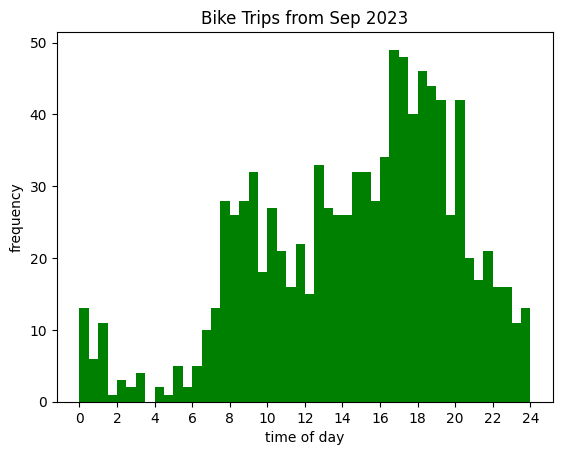

In [ ]:
start_times = np.array(small_time.select("start_seconds").collect())
end_times = np.array(small_time.select("end_seconds").collect())

# Normalize the times to between 0 and 24
s = 60 * 60
start_times = start_times / s
end_times = end_times / s

h = 0.5 # bin width in hours
plt.hist(start_times, bins = np.linspace(0, 24, int(24 / h + 1)), color = "green");
plt.xticks(np.linspace(0, 24, 13));
plt.title("Bike Trips from Sep 2023");
plt.ylabel("frequency");
plt.xlabel("time of day");
plt.show();

In [ ]:
# Set k, the number of clusters for K-means
k = 5

# Pick the first k points as a "random" initialization of centroids
random_centroids = start_times[:k]

print(start_times.shape)
print(random_centroids.shape)

(1000, 1)
(5, 1)


In [ ]:
## K-means algorithm ##

def K_means(data, centroids, max_iter, norm):

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the 2-norm distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # calculate the cost(s) for the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i] # can change to c1 or c2
              dists[i] = np.linalg.norm(x_row - c_row, norm)

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids

        # print the cost for each iteration
        #print("cost after iteration ", t, ": ", int(costs[t]))

    # return the costs
    return costs, new_centroids;

In [ ]:
# Run k-means algorithm on start_times data
costs, clusters = K_means(start_times, random_centroids, max_iter = 100, norm = 2)

print(costs[-1])
print(clusters)


## Time to run ##

# 10,000 points, 100 iterations = 32 seconds (TPU)

1484.3640875138633
[[13.70558148]
 [21.33056471]
 [ 8.88703338]
 [ 1.41540052]
 [17.65481366]]


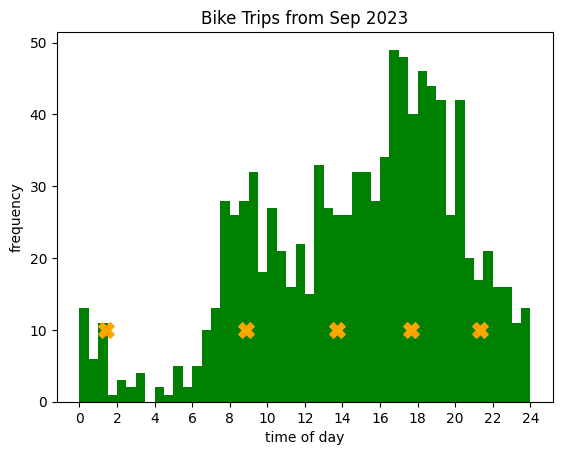

In [ ]:
# Plot the same histogram as before, now showing the cluster centroids

h = 0.5 # bin width in hours
plt.hist(start_times, bins = np.linspace(0, 24, int(24 / h + 1)), color = "green");
plt.scatter(clusters, np.repeat(10, len(clusters)), c = "orange", marker = 'X',
            s = 123);
plt.xticks(np.linspace(0, 24, 13));
plt.title("Bike Trips from Sep 2023");
plt.ylabel("frequency");
plt.xlabel("time of day");
plt.show();

In [ ]:
## TO DO

# 1)
# Assign each point to its respective cluster, so we can look at each cluster
# of points separately

# 2)
# Just take the min of two subtractions
# NO --> Consider transforming to polar coordinates so we don't get an artificial
# separation between times just before and after midnight


In [ ]:
# Starting to work on a distance measure for space
# What I'm thinking could work is:
#
# dist(start1, start2) + dist(end1, end2) + gamma * sin theta
#
# (where theta is the angle between the two trip trajectories,
#  and gamma controls how we much we weight the sine compared
#  to the distances)
#
# Computing *all* of these pair-wise distances is infeasible,
# though. We need a clever-er way to do it, perhaps using
# a dynamic programming approach.
#
# Ah! We don't need to compute *all* pair-wise distances in
# order to do k-means clustering. We just need to compute the
# distance from each point to each centroid (right?). So
# we could just modify the K-means algorithm above to use
# our custom distance measure instead of the 2-norm.

a = [0, 1]
b = [1, 1]

sin = np.abs(np.cross(a, b)) / (np.linalg.norm(a) * np.linalg.norm(b))
theta = np.arcsin(sin)
print(theta * 180 / np.pi)
print(sin)

# Visualize the two vectors as points
# plt.scatter(a[0], a[1]);
# plt.scatter(b[0], b[1]);
# plt.xticks([-1, 1]);
# plt.yticks([-1, 1]);

45.0
0.7071067811865475


In [ ]:
## K-means algorithm 2 ##
# Let's slim down the computation for 1D time data
# And also add in the "wrap-around": taking the minimum
# of |t2 - t1| and 24 - |t2 - t1|

def K_means_time(data, centroids, max_iter, norm):

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the 2-norm distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # calculate the cost(s) for the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]
              # perform the wrap-around, finding the minimum distance in
              # 24-hour time
              s = 24 * 60 * 60
              dists[i] = np.min([np.abs(x_row - c_row),
                                 s - np.abs(x_row - c_row)])

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids

        # print the cost for each iteration
        #print("cost after iteration ", t, ": ", int(costs[t]))

    # return the costs
    return costs, new_centroids, clusters;

In [ ]:
# Run k-means algorithm on start_times data
costs, centroids, clustering = K_means_time(start_times, random_centroids,
                                            max_iter = 10, norm = 2)

print(costs[-1])
print(centroids)
print(clustering[:20])

## Time to run ##


2239.5039588147065
[[15.27547467]
 [21.98028916]
 [10.31664785]
 [ 4.44182456]
 [18.66394219]]
[4. 1. 2. 2. 1. 1. 0. 2. 0. 0. 2. 2. 4. 0. 2. 2. 4. 0. 4. 2.]


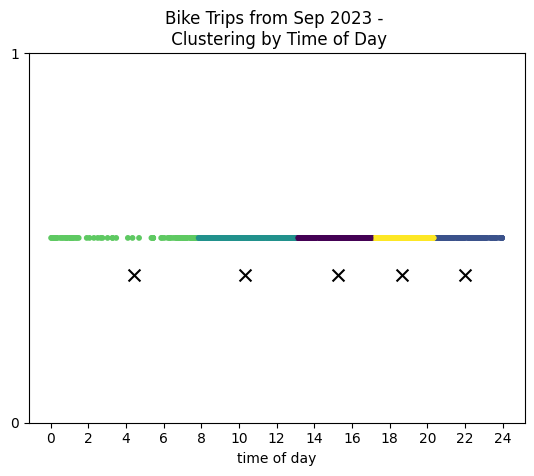

In [ ]:
# Let's try to visualize the clusters as different colors

#h = 0.5 # bin width in hours
plt.scatter(start_times, np.repeat(0.5, len(clustering)), c = clustering,
            cmap = 'viridis', s = 10);
#plt.colorbar(label = "Colors");
plt.scatter(centroids, np.repeat(0.4, len(centroids)), c = "black", marker = 'x',
            s = 73);
plt.xticks(np.linspace(0, 24, 13));
plt.yticks([0, 1]);
plt.title("Bike Trips from Sep 2023 - \n Clustering by Time of Day");
#plt.ylabel("frequency");
plt.xlabel("time of day");
plt.show();

In [ ]:
# Now let's tackle space
small.show()
small_space = small.drop("start_time", "end_time")
small_space.show()

+------------------+------------------+-----------------+------------------+----------+--------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_time|end_time|
+------------------+------------------+-----------------+------------------+----------+--------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|  17:15:28|17:19:00|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|  21:45:29|21:53:33|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  11:59:58|12:23:02|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|  09:09:07|09:14:27|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  20:34:25|20:41:56|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  21:14:06|21:36:29|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|  16:28:47|16:52:19|
|      40.672714114|     -73.9

In [ ]:
# Function to compute the true distance between two points on Earth's surface
import math

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

# Example usage
lat1, lon1 = 40.7128, -74.0060  # Latitude and longitude of New York City
lat2, lon2 = 34.0522, -118.2437  # Latitude and longitude of Los Angeles

distance = haversine(lat1, lon1, lat2, lon2)
print("Distance between New York City and Los Angeles is {:.2f} kilometers".format(distance))


Distance between New York City and Los Angeles is 3935.75 kilometers


In [ ]:
# Function to compute the straight-line distance between two points on Earth's
# surface, which approximates the true distance

def latlon_dist(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers (average radius)
    radius = 6371.0

    # Euclidean distance approximation
    distance = math.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2) * radius

    return distance

# Example usage
lat1, lon1 = 40.7128, -74.0060  # Latitude and longitude of New York City
lat2, lon2 = 34.0522, -118.2437  # Latitude and longitude of Los Angeles

distance = latlon_dist(lat1, lon1, lat2, lon2)
print("Distance between New York City and Los Angeles is about {:.2f} kilometers".format(distance))


Distance between New York City and Los Angeles is about 4974.45 kilometers


In [ ]:
# Let's collect the spatial data into an array
small_space_arr = np.array(small_space.collect())
print(small_space_arr[:10, :])

[[ 40.68494    -73.92299     40.68822    -73.91966   ]
 [ 40.73240447 -73.99839389  40.722055   -73.989111  ]
 [ 40.78232261 -73.95987511  40.78866499 -73.96680057]
 [ 40.75009768 -73.91349703  40.756913   -73.921631  ]
 [ 40.78232261 -73.95987511  40.78866499 -73.96680057]
 [ 40.78232261 -73.95987511  40.78866499 -73.96680057]
 [ 40.78232261 -73.95987511  40.78866499 -73.96680057]
 [ 40.67271411 -73.9541539   40.66846    -73.9282    ]
 [ 40.7597108  -73.97402311  40.78866499 -73.96680057]
 [ 40.78232261 -73.95987511  40.78866499 -73.96680057]]


In [ ]:
# Function to find the distance between the starting points of two trips
def starts_dist(u, v):
    lat1 = u[0]
    lon1 = u[1]
    lat2 = v[0]
    lon2 = v[1]
    #print(lat1, lon1)
    #print(lat2, lon2)

    return haversine(lat1, lon1, lat2, lon2);

# Function to find the distance between the ending points of two trips
def ends_dist(u, v):
    lat1 = u[2]
    lon1 = u[3]
    lat2 = v[2]
    lon2 = v[3]
    #print(lat1, lon1)
    #print(lat2, lon2)

    return haversine(lat1, lon1, lat2, lon2);

# Last but not least, a function to find the sine of the angle between two
# vectors
# May only use this if we resort to straight-line approximations
def sine_vecs(a, b):
    return np.abs(np.cross(a, b)) / (np.linalg.norm(a) * np.linalg.norm(b));

In [ ]:
# Let's check the distances between the starting points and between the ending
# points of rows 0 and 1 of the small_space_arr
print(starts_dist(small_space_arr[0], small_space_arr[1]))
print(ends_dist(small_space_arr[0], small_space_arr[1]))

8.261422210744486
6.959005793586105


In [ ]:
# Function to find the initial bearing from the start station to the end station

def calculate_initial_bearing(lat1, lon1, lat2, lon2):
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)

    initial_bearing = math.atan2(y, x)

    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# Example usage
lat1, lon1 = 40.7128, -74.0060  # Latitude and longitude of New York City
lat2, lon2 = 34.0522, -118.2437   # Latitude and longitude of Los Angeles

bearing = calculate_initial_bearing(lat1, lon1, lat2, lon2)
print("Initial bearing from New York City to Los Angeles is {:.2f} degrees.".format(bearing))


Initial bearing from New York City to Los Angeles is 273.69 degrees.


In [ ]:
# Function to calculate the absolute value of the sine of the difference in
# initial bearings between two trips

def sine_bearings(u, v):
    u_bearing = calculate_initial_bearing(u[0], u[1], u[2], u[3])
    v_bearing = calculate_initial_bearing(v[0], v[1], v[2], v[3])

    return np.abs(np.sin(np.abs(u_bearing - v_bearing)));

sine_bearings(small_space_arr[0], small_space_arr[1])

0.9833763979554101

In [ ]:
# Function to calculate the spatial cost between two trips
# cost = dist(start1, start2) + dist(end1, end2) + gamma * sin(theta)
# where theta is the difference in initial bearings of the two trips

def spatial_cost(u, v, gamma):

    gamma = gamma # just guessing this hyper-parameter for now
                  # 12.65 = 0.5*(length + width) of Manhattan

    # Calculate the cost according to the formula
    cost = starts_dist(u, v) + ends_dist(u, v) + gamma * sine_bearings(u, v)

    return cost;

spatial_cost(small_space_arr[12], small_space_arr[1], 12.65 / 3)

10.014586948273166

In [ ]:
# Calculate the true midpoint of two points on Earth's surface

def midpoint(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Difference in longitudes
    dlon = lon2 - lon1

    # Calculate midpoint
    Bx = math.cos(lat2) * math.cos(dlon)
    By = math.cos(lat2) * math.sin(dlon)
    lat_m = math.atan2(math.sin(lat1) + math.sin(lat2), math.sqrt((math.cos(lat1) + Bx)**2 + By**2))
    lon_m = lon1 + math.atan2(By, math.cos(lat1) + Bx)

    # Convert back to degrees
    lat_m = math.degrees(lat_m)
    lon_m = math.degrees(lon_m)

    return lat_m, lon_m

# Example usage
lat1, lon1 = 40.7128, -74.0060  # Latitude and longitude of New York City
lat2, lon2 = 34.0522, -118.2437   # Latitude and longitude of Los Angeles

avg_lat, avg_lon = midpoint(lat1, lon1, lat2, lon2)
print("Average location (midpoint) between New York City and Los Angeles is: Latitude = {:.6f}, Longitude = {:.6f}".format(avg_lat, avg_lon))

Average location (midpoint) between New York City and Los Angeles is: Latitude = 39.510308, Longitude = -97.160132


In [ ]:
# My attempt to calculate the true midpoint of two trips (starts and ends separately)
# Not gonna use this for now

def midpoint_two_trips(u, v):
    mid_start_lat, mid_start_lon = midpoint(u[0], u[1], v[0], v[1])
    mid_end_lat, mid_end_lon = midpoint(u[2], u[3], v[2], v[3])

    return [mid_start_lat, mid_start_lon, mid_end_lat, mid_end_lon];

print(small_space_arr[:2])
midpoint_two_trips(small_space_arr[0], small_space_arr[1])

[[ 40.68494    -73.92299     40.68822    -73.91966   ]
 [ 40.73240447 -73.99839389  40.722055   -73.989111  ]]


[40.70867836773313, -73.96067851019667, 40.70514270254047, -73.95437667920224]

In [ ]:
# ChatGPT's attempt to calculate the true centroid of n points on Earth's surface
# Not gonna use this for now

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

def calculate_centroid(points):
    total_weighted_lat = 0
    total_weighted_lon = 0
    total_distance = 0

    # Calculate total weighted midpoints
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            lat1, lon1 = points[i]
            lat2, lon2 = points[j]

            # Calculate distance between points
            distance = haversine(lat1, lon1, lat2, lon2)

            # Calculate midpoint
            mid_lat = (lat1 + lat2) / 2
            mid_lon = (lon1 + lon2) / 2

            # Weight the midpoint by the distance between the points
            total_weighted_lat += mid_lat * distance
            total_weighted_lon += mid_lon * distance
            total_distance += distance

    # Normalize by dividing by the total sum of distances
    centroid_lat = total_weighted_lat / total_distance
    centroid_lon = total_weighted_lon / total_distance

    return centroid_lat, centroid_lon

# Example usage
points = [(40.7128, -74.0060), (34.0522, -118.2437), (51.5074, -0.1278)]  # Latitudes and longitudes of New York City, Los Angeles, and London

centroid_lat, centroid_lon = calculate_centroid(points)
print("Centroid of the specified points is: Latitude = {:.6f}, Longitude = {:.6f}".format(centroid_lat, centroid_lon))
print("Simple average is:", np.mean(points, axis = 0))

Centroid of the specified points is: Latitude = 42.632393, Longitude = -60.400104
Simple average is: [ 42.0908     -64.12583333]


In [ ]:
# Let's process the time data into the units we want, keeping the space
# data this time
small_time_and_space = to_seconds(small)
small_time_and_space = small_time_and_space.drop("start_time", "end_time")
small_time_and_space.show()

small_time_and_space_arr = np.array(small_time_and_space.collect())
print(small_time_and_space_arr[:10])

+------------------+------------------+-----------------+------------------+-------------+-----------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_seconds|end_seconds|
+------------------+------------------+-----------------+------------------+-------------+-----------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|        62128|      62340|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|        78329|      78813|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        43198|      44582|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|        32947|      33267|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        74065|      74516|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        76446|      77789|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.966800570487

In [ ]:
## K-means algorithm 3 ##
# Now, let's add in space, using the cost formula developed above.
# For now, I'm just going to implement a simple average of the latitudes and
# longitudes to get the centroids, and not worry about the curvature of the
# Earth (though everything else so far accounts for curvature)

# Start time will be hard-coded as column index 4 for now

def K_means_time_and_space(data, centroids, max_iter, norm, lam, gam):

    # The number of seconds in a day (will need later):
    s = 24 * 60 * 60

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the 2-norm distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # start by calculating the time cost
              x_start_time = x_row[4]
              c_start_time = c_row[4]

              # perform the wrap-around, finding the minimum distance in 24-hour
              # time
              dists[i] = lam * np.min([np.abs(x_start_time - c_start_time),
                                 s - np.abs(x_start_time - c_start_time)])
              #print("time cost = ", dists[i])

              # now add the spatial cost
              dists[i] += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)
              #print("spatial cost = ", spatial_cost(x_row[:4], c_row[:4]))

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids

        # print the cost for each iteration
        #print("cost after iteration ", t, ": ", int(costs[t]))

    # return the costs
    return costs, new_centroids, clusters;

In [ ]:
# Set k, the number of clusters for K-means
k = 5

# Pick the first k points as a "random" initialization of centroids
random_centroids = small_time_and_space_arr[:k]

print(small_time_and_space_arr.shape)
print(random_centroids.shape)



# Run k-means time & space algorithm on small_space_and_time data
# lam (a hyper-parameter between 0 and 1) controls how much we weight space
# vs. time in our calculation of the cost. The smaller lam is, the more space
# is weighted.
costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                      random_centroids,
                                                      max_iter = 100, norm = 2,
                                                      lam = 5e-4,
                                                      gam = 12.65 / 3)
# As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
# dominating

print(costs[-1])
print(centroids) # end times don't have meaning here
print(clustering[:20])

## Time to run ##

# 1,000 points, 100 iterations, 5 clusters = 12 seconds (TPU)

(1000, 6)
(5, 6)
157751.71986390205
[[ 4.06813322e+01 -7.39721516e+01  4.06814861e+01 -7.39652410e+01
   6.04677222e+04  6.11533958e+04]
 [ 4.07228470e+01 -7.39737555e+01  4.07215429e+01 -7.39730826e+01
   6.29893619e+04  6.32630778e+04]
 [ 4.07797695e+01 -7.39585984e+01  4.07839103e+01 -7.39567585e+01
   3.61025108e+04  3.69222518e+04]
 [ 4.07091398e+01 -7.39691519e+01  4.07089319e+01 -7.39694070e+01
   3.25800939e+04  3.31440884e+04]
 [ 4.07771596e+01 -7.39583229e+01  4.07867037e+01 -7.39545448e+01
   6.18117706e+04  6.11997921e+04]]
[0. 1. 2. 2. 4. 4. 4. 3. 4. 4. 2. 3. 4. 1. 2. 3. 4. 1. 1. 2.]


In [ ]:
## Prepare to visualize

# Let's look at just the start location and start time for easier visualization
time_and_space_3D = small_time_and_space_arr[:, [0, 1, 4]]
#print(time_and_space_3D[:10])

# And the centroids too!
c_lats = centroids[:, 0]
c_lons = centroids[:, 1]
c_times = centroids[:, 4]

# Normalize the times (will become y) to between 0 and 24
s = 60 * 60
time_and_space_3D[:, 2] = time_and_space_3D[:, 2] / s
c_times = c_times / s
#print(time_and_space_3D[:10])

# Normalize the latitudes (will become z) to between 0 and 1
min = np.min(time_and_space_3D[:, 0])
max = np.max(time_and_space_3D[:, 0])
#print(min, max)
time_and_space_3D[:, 0] = (time_and_space_3D[:, 0] - min) / (max - min)
c_lats = (c_lats - min) / (max - min)
#print(time_and_space_3D[:10])

# Likewise, normalize the longitudes (will become x) to between 0 and 1
min = np.min(time_and_space_3D[:, 1])
max = np.max(time_and_space_3D[:, 1])
#print(min, max)
time_and_space_3D[:, 1] = (time_and_space_3D[:, 1] - min) / (max - min)
c_lons = (c_lons - min) / (max - min)
print(time_and_space_3D[:10])

[[ 0.182591    0.63100091 17.25777778]
 [ 0.38607973  0.12152823 21.75805556]
 [ 0.60008777  0.38178362 11.99944444]
 [ 0.46193371  0.69514095  9.15194444]
 [ 0.60008777  0.38178362 20.57361111]
 [ 0.60008777  0.38178362 21.235     ]
 [ 0.60008777  0.38178362 16.47972222]
 [ 0.13017642  0.42043946  8.30222222]
 [ 0.50314688  0.28619146 15.04055556]
 [ 0.60008777  0.38178362 16.47      ]]


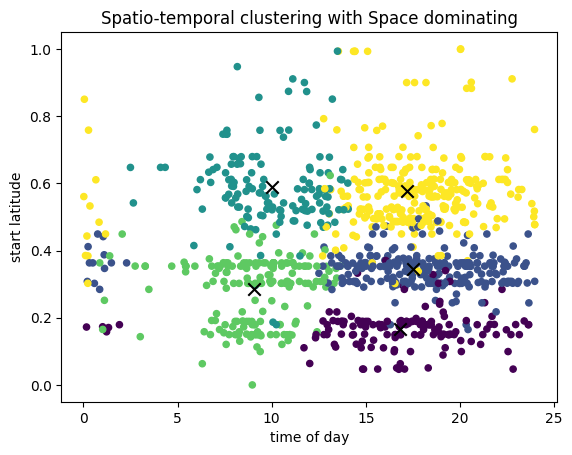

In [ ]:
# Let's give our array a shorter name, please
arr = time_and_space_3D

# Store starting lat and lon, and start time
lats = arr[:, 0]
lons = arr[:, 1]
times = arr[:, 2]

plt.scatter(times, lats, c = clustering, cmap = 'viridis', s = 20);
plt.scatter(c_times, c_lats, c = "black", marker = 'x', s = 80);
plt.title("Spatio-temporal clustering with Space dominating");
plt.xlabel("time of day");
plt.ylabel("start latitude");

<ipython-input-635-5393f03afb61>:22: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11;


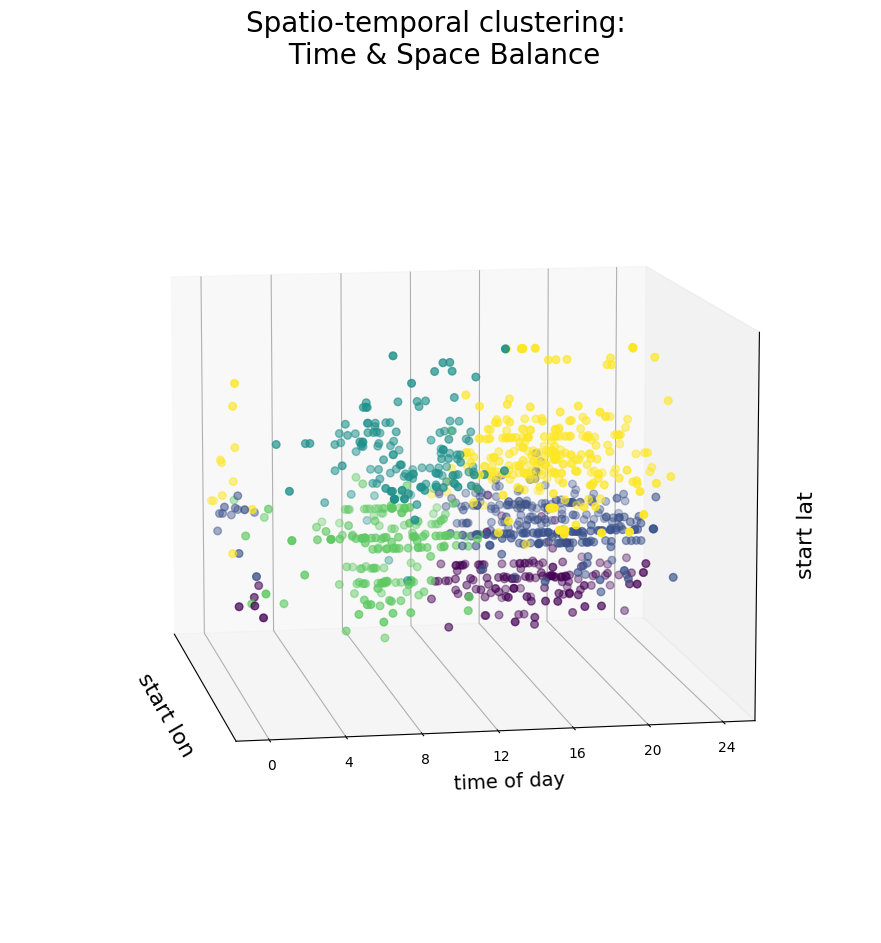

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection='3d')
fig.tight_layout(pad = 5.0)

ax.scatter(lons, times, lats, c = clustering, cmap = 'viridis', s = 30);

ax.set_xticks([]);
ax.set_zticks([]);
ax.set_yticks(np.linspace(0, 24, 7));

title = ax.set_title("Spatio-temporal clustering: \n Time & Space Balance", fontsize = 20);
ax.set_xlabel("start lon", fontsize = 16);
ax.set_zlabel("start lat", fontsize = 16);
ax.set_ylabel("\n time of day", fontsize = 14);
title.set_position([0.5, 1]);


ax.view_init(10, -10, 0);
ax.dist = 11;